# Training a RL agent with Stable Baselines3 using a GEM environment

This notebook serves as an educational introduction to the usage of stable-baselines3 using a GEM environment. Goal of this notebook is to give an understanding what Stable Baselines3 is and how to use it to train and evaluate a Reinforcement Learning agent which is able to solve a current control problem of the GEM toolbox.

The following code snippets are only needed if you are executing this file directly from a cloned GitHub repository where you don't have GEM installed

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent.parent))

## 1. What you need

Before you can start you need to make sure that you have both gym-electric-motor and Stable-Baselines3 installed. You can install both easily using pip:

- pip install gym-electric-motor
- pip install stable-baselines3

Alternatively, you can install them and their latest developer version directly from GitHub:

- https://github.com/upb-lea/gym-electric-motor
- https://github.com/DLR-RM/stable-baselines3

You also need to make sure that numpy and gym are installed. You can install both using pip, too. After you have done that you should be able to execute the following cells without any problems.

## 2. Setting up a GEM evironment

This notebook does not focus directly on the usage of GEM and how to set up a GEM environment. If you are new to GEM and interested to find out what it does and how to use it we recommend taking a look at the educational notebook which is dealing with GEM.


For this notebook, we will use a function defined in an external Python file called setting_environment.py. If you are interested to see how we defined our environment's parameters you can take a look at that file. We are using the Discrete Permanent Magnet Synchronous Motor Environment:

- https://upb-lea.github.io/gym-electric-motor/parts/environments/pmsm_disc.html

- https://upb-lea.github.io/gym-electric-motor/parts/physical_systems/electric_motors/pmsm.html

The motor schematic is the following:

![Motor Setup](img/ESBdq1.svg)

And the electrical ODEs for that motor are:

<h3 align="center">

$\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>

In GEM the agent controls the converter who converts the supply currents to the currents flowing into the motor - in our motor's case $i_{sq}$ and $i_{sd}$:

![Motor Setup](img/SCML_Setting.svg)


In the continuous case the agent's action is controlling the converter's output voltage directly through means of duty cycling. In the discrete case the agent's action decides which converter switches are open and which are closed. Therefore, only a discrete amount of options are available. For this environment we are using the Discrete B6 Bridge Converter which has three switches which amounts to a total of eight possible actions the agent can take:

![Motor Setup](img/B6.svg)



We wish for an agent to be able to control the currents freely. For this a reference generator generates a trajectory which the agent has to follow. Therefore, he has to internally learn to solve the ODEs and convert voltages accordingly. The following code is using our pre-written function set_env to import our pre-defined GEM environment. We are also using the callback RewardLogger to visualize our training progress after training.

In [2]:
from gym_electric_motor.core import Callback
class RewardLogger(Callback):
    def __init__(self):
        self._step_rewards = []
        self._mean_episode_rewards = []

    def on_step_end(self):
        self._step_rewards.append(self._env._reward)
    
    def on_reset_begin(self):
        self._mean_episode_rewards.append(np.mean(self._step_rewards))
        self._step_rewards = []
        
    def on_close(self):
        np.save(Path.cwd() / "saved_agents" / "EpisodeRewards.npy", np.array(self._mean_episode_rewards))

/home/darius/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
from setting_environment import set_env
env = set_env(training=True, callbacks=[RewardLogger()])

## 3. What is Stable Baselines3?



Stable Baselines3 is a collection of Reinforcement Learning algorithms implemented in Pytorch. It can be used in a scenario where you want to train an agent of a specific RL algorithm when you don't want to implement the algorithm yourself.

Stable Baselines3 is still a very new library with it's current release being 0.9. That is why its selection of algorithms is not very large yet and most algorithms lack more sophisticated variants. However, it is planned for the future to broaden the available algorithms. For currently available algorithms see their documentation:

- https://stable-baselines3.readthedocs.io/en/master/guide/rl.html

To use an agent provided by Stable Baselines3 your environment has to have a gym interface:

- https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html

## 4. Training an agent

To train an agent in Stable Baselines3 you need two things: The agent and a function approximator representing the control policy. The agent is the algorithm you want to use to solve your problem. The policy defines the function estimation you want to use. Mostly supported are MLP and CNN function estimators. Check the algorithm in the documentation to see what estimator the algorithm you want to use supports. In the future recurrent functions estimators are supposed to be implemented, too.

### 4.1 Imports

In our control problem we have an environment with a discrete action space. Therefore, we decided for the Deep-Q-Network (DQN):

- https://arxiv.org/abs/1312.5602

For the implementation of the DQN you can check Stable Baslines3's docs and see, that currently the MLP and the CNN are supported:

- https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html

In this tutorial we use MLP. That is why we have to import the DQN and the MlpPolicy. You can also see which gym spaces for the observation and the actions are supported. You might have to take that into account for your environment. For GEM we had to flatten the observation because Stable Baselines3 does not support tuples as observations.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy

### 4.2 Setting the parameters

For the DQN algorithm we have to define a set of values. The policy_kwargs dictionary is a parameter which is directly given to the MlpPolicy. The net_arch key defines the network architecture of our MLP.

In [5]:
buffer_size = 200000 #number of old obsersation steps saved
learning_starts = 10000 # memory warmup
train_freq = 1 # prediction network gets an update each train_freq's step
batch_size = 25 # mini batch size drawn at each update step
policy_kwargs = {
        'net_arch': [64,64] # hidden layer size of MLP
        }
exploration_fraction = 0.1 # Fraction of training steps the epsilon decays 
target_update_interval = 1000 # Target network gets updated each target_update_interval's step
gamma = 0.99
verbose = 1 # verbosity of stable basline's prints

Additionally, we have to define how long our agent will train. We can just set a concrete number of steps or use our knowledge of the environment's temporal resolution to define an in-simulation training time. In this example we want to train the agent for 5 seconds which will translate to 500000 steps.

In [6]:
tau = 1e-5
simulation_time = 5 # seconds
nb_steps = int(simulation_time // tau)

### 4.3 Starting the training

Once you've setup the environment and defined your parameters starting the training is nothing more than a one-liner. For each algorithm all you have to do is call its .learn() function. However, you should note that the execution of the training can take a long time. Currently, Stable Baselines3 does not provide any means of reward observation during training. Therefore, we are using a callback for our GEM environment called RewardLogger (see code a few cells above).

In [ ]:
model = DQN(MlpPolicy, env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, 
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            exploration_fraction=exploration_fraction, target_update_interval=target_update_interval,
            verbose=verbose)
model.learn(total_timesteps=nb_steps)
env.close()

### 4.4 Saving the model

When the training has finished you can save the model your DQN has learned to reuse it later, e.g. for evaluation or if you want to continue your training. For this, each Stable Baselines3 algorithm has a .save() function where you only have to specify your path.

In [ ]:
model.save(Path.cwd() / "saved_agents" / "TutorialAgent")

## 5. Evaluating an agent

After you have trained your agent you would like to see how well it does on your control problem. For this you can for example look at a visual representation of your currents in a test trajectory or see how well your agent does in a test scenario.

### 5.1 Loading a model

First, before we start our evaluation we have to load a trained agent or take the trained agent from the same code. To load an trained agent you only have to call the .load() function of your algorithm with the respective path. If you have executed the provided code above you can uncomment the first line of code and comment the second one.

In [7]:
#model = DQN.load(Path(__file__).parent / "saved_agents" / "TutorialAgent")  #your agent
model = DQN.load(Path.cwd() / "saved_agents" / "TutorialPreTrainedAgent") #pre-trained agent

### 5.2 Taking a look at the mean reward per episode during training

Our callback saved the mean reward per episode during training. There we can observe, if the reward did grow over time. Uncomment the first line and comment the second line if you have executed the training cell. An examplary graph could look like this:

![TrainingRew](img/TrainingRewEpisode.png)

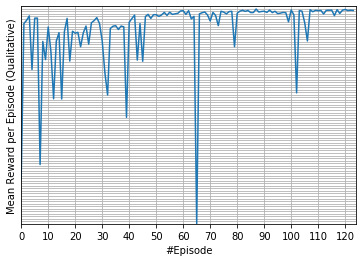

In [8]:
#rewards = np.load(Path.cwd() / "saved_agents" / "EpisodeRewards.npy")[1:] # your training rewards
rewards = np.load(Path.cwd() / "saved_agents" / "PreTrainedEpisodeRewards.npy")[1:] # pre-trained training rewards
plt.grid(True)
plt.xlim(0,len(rewards))
plt.ylim(min(rewards), 0)
plt.yticks(np.arange(min(rewards), 1, 1.0))
plt.tick_params(axis = 'y', left = False, labelleft = False)
plt.xticks(np.arange(0, len(rewards), 10))
plt.xlabel('#Episode')
plt.ylabel('Mean Reward per Episode (Qualitative)')
plt.plot(rewards)
plt.show()

### 5.3 Taking a look at a test trajectory

We want to take a look at a test trajectory and see how well the trained agent is able to control the currents to follow the test trajectory. For the agent to decide for an action given an observation you can just call its .predict() function. The key deterministic is important so that the agent is not using a stochastic policy like epsilon greedy but is instead chosing an action greedily. A possible trajectory can be seen below. The blue trajectory is the one induced by the agent's actions while the green one is optimal:

![Motor Setup](img/example_trajectory2.png)

/home/darius/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


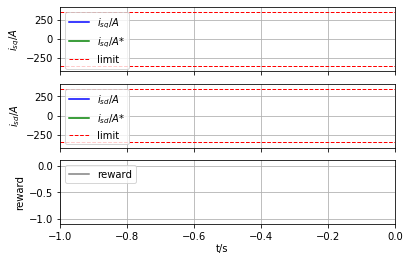

KeyboardInterrupt: 

In [9]:
%matplotlib notebook
env = set_env(time_limit = False, training=False)
visualization_steps = int(9e4) # currently this crashes for larger values
obs = env.reset()
for i in range(visualization_steps):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    env.render()
    if done:
        obs = env.reset()

### 5.4 Calculating further evaluation parameters

With the knowledge you acquired in the previous sections you are now able to train and evaluate any in Stable Baselines3 available reinforcement learning algorithm. The code below should give you an example how to use the trained agent to calculate a mean reward and mean episode length over a specific amount of steps. For further questions you can always have a look at the documentation of gym-electric-motor and Stable Baselines3 or raise an issue in their respective GitHub repositories.

In [ ]:
test_steps = int(1e5) #1 milion for stability reasons
cum_rew = 0
episode_step = 0
episode_lengths = []
for i in range(test_steps):
    print(f"{i+1}", end = '\r')
    episode_step += 1
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    cum_rew += reward
    if done:
        episode_lengths.append(episode_step)
        episode_step = 0
        obs = env.reset()
print(f"The reward per step with {test_steps} steps was: {cum_rew/test_steps:.4f} ")
print(f"The average Episode length was: {round(np.mean(episode_lengths))} ")
